<a href="https://colab.research.google.com/github/sharatkatz/dl-playground/blob/main/temp_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! wget -c  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
! unzip jena_climate_2009_2016.csv.zip

--2021-07-19 10:33:44--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.81.142
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.81.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  13.1MB/s    in 1.0s    

2021-07-19 10:33:46 (13.1 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [3]:
data_dir = '.'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [4]:
# Parse the data
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
print(float_data.shape)

(420451, 14)


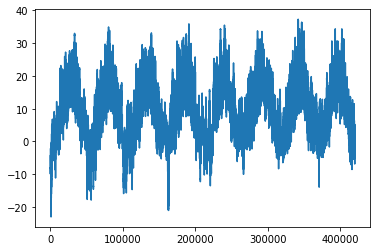

In [5]:
temp = float_data[:, 1] # <1> temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

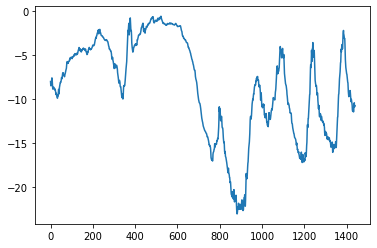

In [6]:
plt.plot(range(1440), temp[:1440])

In [7]:
# Normalizing the data

mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

# generator function used to feed the training, validation and test data

def generator(data, lookback, delay, min_index, max_index,
                shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                    min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=0,
                        max_index=200000,
                        shuffle=True,
                        step=step,
                        batch_size=batch_size)
val_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=200001,
                        max_index=300000,
                        step=step,
                        batch_size=batch_size)
test_gen = generator(float_data,
                        lookback=lookback,
                        delay=delay,
                        min_index=300001,
                        max_index=None,
                        step=step,
                        batch_size=batch_size)

val_steps = (300000 - 200001 - lookback)  // batch_size # How many steps to draw from
            # val_gen in order to see the entire validation set
test_steps = (len(float_data) - 300001 - lookback)  // batch_size # How many steps to draw
        # from test_gen in order to see the entire test set 

In [8]:
def plot_history(loss, val_loss):
  epochs = range(1, len(loss) + 1)
  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

In [15]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
500/500 [==============================] - 14s 26ms/step - loss: 2.0470 - val_loss: 0.6432
Epoch 2/20
500/500 [==============================] - 13s 26ms/step - loss: 0.5596 - val_loss: 0.3498
Epoch 3/20
500/500 [==============================] - 13s 27ms/step - loss: 0.3206 - val_loss: 0.3021
Epoch 4/20
500/500 [==============================] - 13s 27ms/step

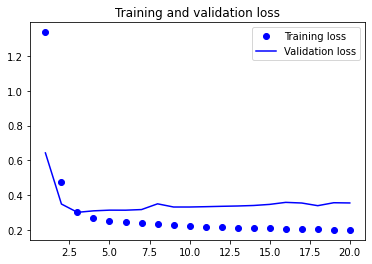

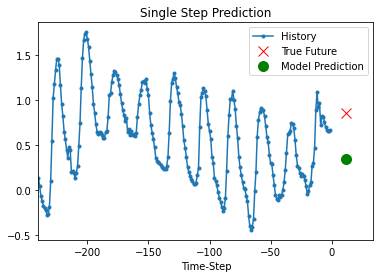

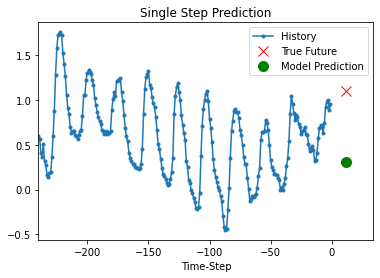

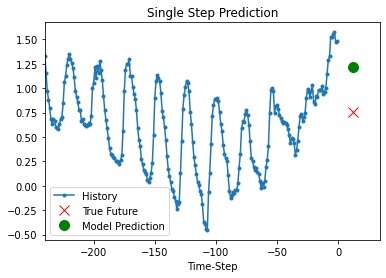

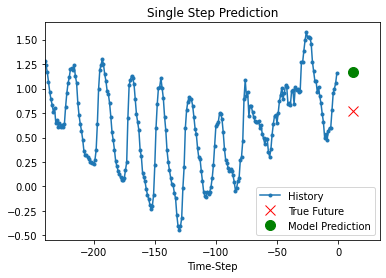

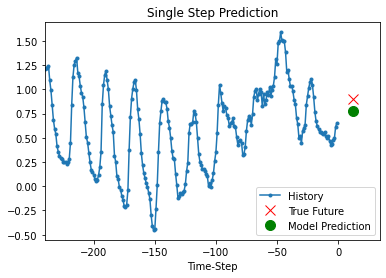

In [17]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
print(model.summary())

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit(train_gen,
                   steps_per_epoch=500,
                   epochs=20,
                   validation_data=val_gen,
                   validation_steps=val_steps)

_ = plot_history(history.history['loss'], history.history['val_loss'])

for _ in range(5):
    x, y = next(test_gen)
    show_plot(
        [x[0][:, 1], y[0], model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

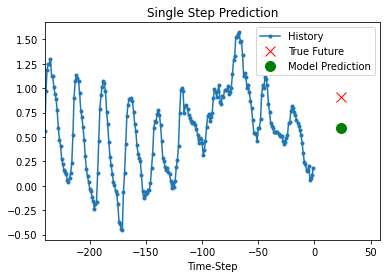

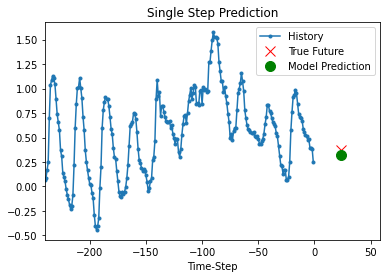

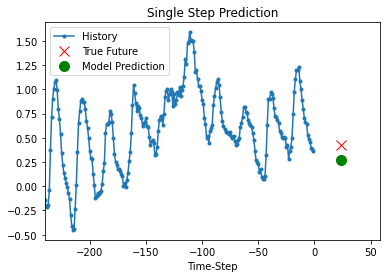

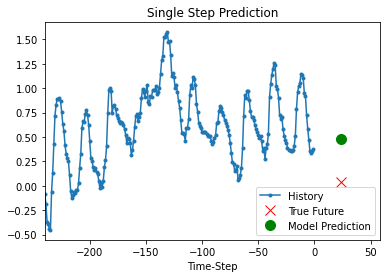

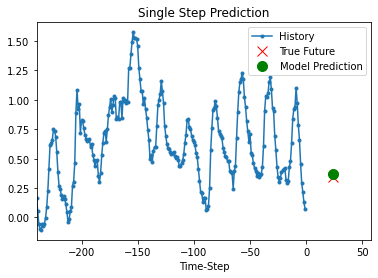

In [18]:
for _ in range(5):
    x, y = next(test_gen)
    show_plot(
        [x[0][:, 1], y[0], model.predict(x)[0]],
        24,
        "Single Step Prediction",
    )